# Sentiment Analysis on Movie Review DataSet of Kaggle

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [51]:
# Reading data

df_train = pd.read_csv('train.tsv', sep='\t')
df_test = pd.read_csv('train.tsv', sep='\t')

In [52]:
df_train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [53]:
df_test.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [54]:
#  Count the categories
df_train.Sentiment.value_counts()

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

In [55]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
PhraseId      156060 non-null int64
SentenceId    156060 non-null int64
Phrase        156060 non-null object
Sentiment     156060 non-null int64
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


### Removing undesired columns


In [56]:
df_train.drop(["PhraseId","SentenceId"], axis=1, inplace=True)

In [57]:
df_train.head()

,Phrase,Sentiment
0,A series of escapades demonstrating the adage ...,1
1,A series of escapades demonstrating the adage ...,2
2,A series,2
3,A,2
4,series,2


In [58]:
df_train['phrase_len'] = [len(phrase) for phrase in df_train.Phrase]
df_train.head(5)

,Phrase,Sentiment,phrase_len
0,A series of escapades demonstrating the adage ...,1,188
1,A series of escapades demonstrating the adage ...,2,77
2,A series,2,8
3,A,2,1
4,series,2,6


### Distribution of length of reviews

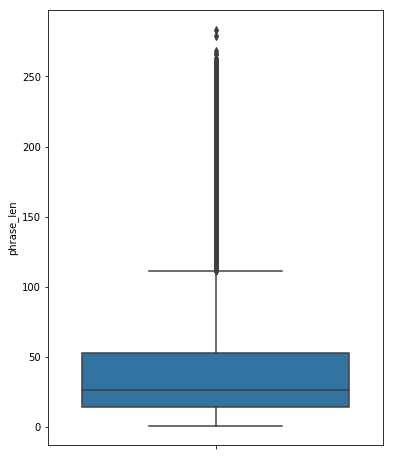

In [59]:
plt.figure(figsize=(6,8))
sns.boxplot(y=df_train.phrase_len)

In [60]:
df_train[df_train.phrase_len > 150].head()

,Phrase,Sentiment,phrase_len
0,A series of escapades demonstrating the adage ...,1,188
116,A positively thrilling combination of ethnogra...,3,152
306,Kung Pow is Oedekerk 's realization of his chi...,1,162
310,is Oedekerk 's realization of his childhood dr...,2,153
311,is Oedekerk 's realization of his childhood dr...,0,151


In [61]:
# Lets see what is inside review
df_train[df_train.phrase_len > 150].loc[116].Phrase

'A positively thrilling combination of ethnography and all the intrigue , betrayal , deceit and murder of a Shakespearean tragedy or a juicy soap opera .'

### Filter out positive and negative reviews

In [62]:
neg_phrases = df_train[df_train.Sentiment == 0]
neg_words = []
for word in neg_phrases.Phrase:
    neg_words.append(word)

neg_words[:4]

['would have a hard time sitting through this one',
 'have a hard time sitting through this one',
 'Aggressive self-glorification and a manipulative whitewash',
 'self-glorification and a manipulative whitewash']

Now combine the list using Pandas.Series.str.cat

In [63]:
neg_text = pd.Series(neg_words).str.cat(sep=' ')
neg_text[:200]

'would have a hard time sitting through this one have a hard time sitting through this one Aggressive self-glorification and a manipulative whitewash self-glorification and a manipulative whitewash Tro'

In [64]:
pos_phrases = df_train[df_train.Sentiment == 4]
pos_words = []
for words in pos_phrases.Phrase:
    pos_words.append(words)
pos_text = pd.Series(pos_words).str.cat(sep=' ')
pos_text[:200]

'This quiet , introspective and entertaining independent is worth seeking . quiet , introspective and entertaining independent entertaining is worth seeking A positively thrilling combination of ethnog'

### WorldCloud for negatively classified reviews

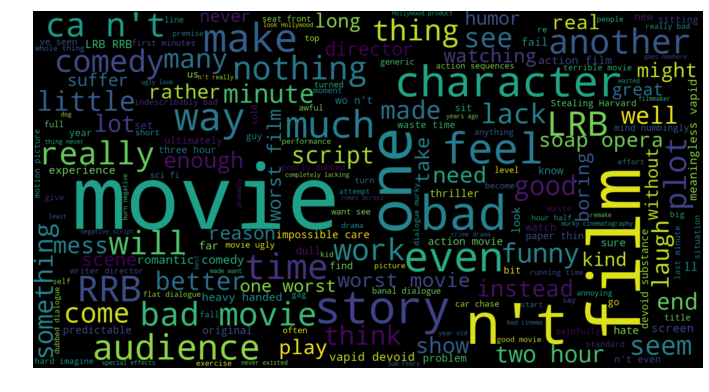

In [65]:
from wordcloud import WordCloud
wordcloud = WordCloud(width=1500, height=800, max_font_size=200).generate(neg_text)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Some of the big words can be interpreted quite neutral, such as "movie","film" etc.

### World Cloud for postively classified movie

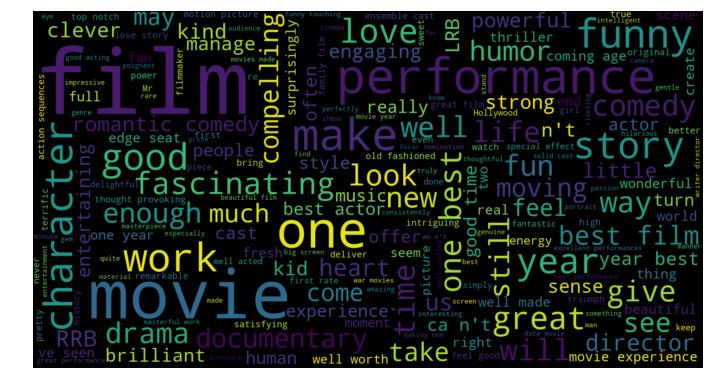

In [66]:
wordcloud = WordCloud(width=1500,height=800, max_font_size=200).generate(pos_text)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Here alsone some neutral words like "movie", "film"
but got positive words like "good", "best", "fascinating" , "well" etc

### Term Frequencies of each Sentiment class

We are going to use Zipf's law.

In [67]:
from sklearn.feature_extraction.text import CountVectorizer
cvector = CountVectorizer(min_df = 0.0, max_df=1.0, ngram_range=(1,2))
cvector.fit(df_train.Phrase)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=0.0,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [68]:
len(cvector.get_feature_names())

94644

### Finding Term Frequency for 'negative' sentiments

In [69]:
neg_matrix = cvector.transform(df_train[df_train.Sentiment == 0].Phrase)
somewhat_neg_matrix = cvector.transform(df_train[df_train.Sentiment == 1].Phrase)
neu_matrix = cvector.transform(df_train[df_train.Sentiment == 2].Phrase)
somewhat_pos_matrix = cvector.transform(df_train[df_train.Sentiment == 3].Phrase)
pos_matrix = cvector.transform(df_train[df_train.Sentiment == 4].Phrase)

In [70]:
neg_words = neg_matrix.sum(axis = 0)
neg_words_freq = [(word, neg_words[0,idx]) for word,idx in cvector.vocabulary_.items()]
#print(neg_words_freq[:10])
neg_tf = pd.DataFrame(list(sorted(neg_words_freq, key= lambda x: x[1], reverse=True)),columns = ['Terms', 'negative'])
neg_tf.head()

,Terms,negative
0,the,3462
1,and,2549
2,of,2277
3,to,1916
4,is,1372


### Term Frequency for somewhat negative

In [71]:
somewhat_neg_words = somewhat_neg_matrix.sum(axis=0)
somewhat_neg_words_freq = [(word, somewhat_neg_words[0, idx]) for word, idx in cvector.vocabulary_.items()]
somewhat_neg_tf = pd.DataFrame(list(sorted(somewhat_neg_words_freq, key = lambda x: x[1], reverse=True)), columns = ['Terms', 'some-negative'])
somewhat_neg_tf.head(10)

,Terms,some-negative
0,the,10885
1,of,6660
2,and,6204
3,to,5571
4,is,3362
5,it,3067
6,that,2982
7,in,2965
8,as,2184
9,for,1739


### Term Frequency for neutral

In [72]:
neu_words = neu_matrix.sum(axis=0)
neu_words_freq = [(word, neu_words[0, idx]) for word, idx in cvector.vocabulary_.items()]
neu_words_tf = pd.DataFrame(list(sorted(neu_words_freq, key = lambda x: x[1], reverse=True)),columns=['Terms', 'neutral'])
neu_words_tf.head(10)

,Terms,neutral
0,the,20619
1,of,12287
2,and,10241
3,to,8295
4,in,5562
5,it,3791
6,is,3703
7,that,3677
8,as,2941
9,for,2939


### Term Frequency for some positive sentiments

In [73]:
somewhat_pos_words = somewhat_pos_matrix.sum(axis=0)
somewhat_pos_words_freq = [(word, somewhat_pos_words[0, idx]) for word, idx in cvector.vocabulary_.items()]

somewhat_pos_words_tf = pd.DataFrame(list(sorted(somewhat_pos_words_freq, key = lambda x: x[1], reverse = True)), columns=['Terms', 'some_postive'])

In [74]:
somewhat_pos_words_tf.head(10)

,Terms,some_postive
0,the,12459
1,and,9180
2,of,8405
3,to,5411
4,is,3489
5,in,3365
6,that,3280
7,it,2927
8,with,2365
9,an,2061


### Term Frequency for Postive Sentiments

In [75]:
pos_words = pos_matrix.sum(axis=0)
pos_words_freq = [(word, pos_words[0, idx]) for word, idx in cvector.vocabulary_.items()]

pos_words_tf = pd.DataFrame(list(sorted(pos_words_freq, key = lambda x: x[1], reverse=True)), columns=['Terms','positive'])
pos_words_tf.head(10)

,Terms,positive
0,the,4208
1,and,4003
2,of,3073
3,to,1568
4,is,1550
5,that,1260
6,in,1067
7,film,949
8,with,929
9,it,863


In [76]:
# Now lets combine all tf's
term_freq_df = pd.concat([neg_tf, somewhat_neg_tf, neu_words_tf, somewhat_pos_words_tf, pos_words_tf], axis=1 )

In [77]:
term_freq_df.head(10)

,Terms,negative,Terms,some-negative,Terms,neutral,Terms,some_postive,Terms,positive
0,the,3462,the,10885,the,20619,the,12459,the,4208
1,and,2549,of,6660,of,12287,and,9180,and,4003
2,of,2277,and,6204,and,10241,of,8405,of,3073
3,to,1916,to,5571,to,8295,to,5411,to,1568
4,is,1372,is,3362,in,5562,is,3489,is,1550
5,that,1139,it,3067,it,3791,in,3365,that,1260
6,it,1086,that,2982,is,3703,that,3280,in,1067
7,in,1038,in,2965,that,3677,it,2927,film,949
8,movie,793,as,2184,as,2941,with,2365,with,929
9,as,757,for,1739,for,2939,an,2061,it,863


In [78]:
# Make all terms colums as index of each tf first
neg_tf_df = neg_tf.set_index('Terms')
somewhat_neg_tf_df = somewhat_neg_tf.set_index('Terms')
neu_words_tf_df = neu_words_tf.set_index('Terms')
somewhat_pos_words_tf_df = somewhat_pos_words_tf.set_index('Terms')
pos_words_tf_df = pos_words_tf.set_index('Terms')
new_term_freq_df = pd.concat([neg_tf_df, somewhat_neg_tf_df, neu_words_tf_df, somewhat_pos_words_tf_df, pos_words_tf_df], axis=1, sort = False)
new_term_freq_df.head(10)

,negative,some-negative,neutral,some_postive,positive
the,3462,10885,20619,12459,4208
and,2549,6204,10241,9180,4003
of,2277,6660,12287,8405,3073
to,1916,5571,8295,5411,1568
is,1372,3362,3703,3489,1550
that,1139,2982,3677,3280,1260
it,1086,3067,3791,2927,863
in,1038,2965,5562,3365,1067
movie,793,1463,2054,1344,587
as,757,2184,2941,2037,732


In [79]:
new_term_freq_df['total'] = new_term_freq_df['negative'] + new_term_freq_df['some-negative'] + new_term_freq_df['neutral'] + new_term_freq_df['some_postive'] + new_term_freq_df['positive']
new_term_freq_df.sort_values(by='total', ascending=False).head(10)

,negative,some-negative,neutral,some_postive,positive,total
the,3462,10885,20619,12459,4208,51633
of,2277,6660,12287,8405,3073,32702
and,2549,6204,10241,9180,4003,32177
to,1916,5571,8295,5411,1568,22761
in,1038,2965,5562,3365,1067,13997
is,1372,3362,3703,3489,1550,13476
that,1139,2982,3677,3280,1260,12338
it,1086,3067,3791,2927,863,11734
as,757,2184,2941,2037,732,8651
with,452,1533,2471,2365,929,7750


### Lets Plot top 500 frequent phrases in movie reviews

Text(0, 0.5, 'Frequency')

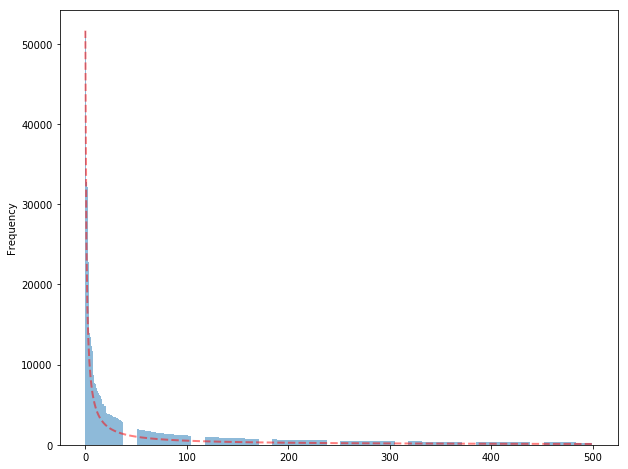

In [80]:
y_pos = np.arange(500)
plt.figure(figsize=(10,8))
s = 1
expected_zipf = [new_term_freq_df.sort_values(by='total', ascending=False)['total'][0]/(i+1)**s for i in y_pos]
plt.bar(y_pos, new_term_freq_df.sort_values(by='total', ascending=False)['total'][:500], align='center', alpha=0.5)
plt.plot(y_pos, expected_zipf, color='r', linestyle='--', linewidth=2, alpha=0.5)
plt.ylabel('Frequency')

### Movie Review Tokenization

In [81]:
from sklearn.feature_extraction.text import CountVectorizer

In [82]:
df_train_1 = df_train.copy()
neg_matrix = cvector.transform(df_train_1[df_train_1.Sentiment == 0].Phrase)
som_neg_matrix = cvector.transform(df_train_1[df_train_1.Sentiment == 1].Phrase)
neu_matrix = cvector.transform(df_train_1[df_train_1.Sentiment == 2].Phrase)
som_pos_matrix = cvector.transform(df_train_1[df_train_1.Sentiment == 3].Phrase)
pos_matrix = cvector.transform(df_train_1[df_train_1.Sentiment == 4].Phrase)

neg_words = neg_matrix.sum(axis=0)
neg_words_freq = [(word, neg_words[0, idx]) for word, idx in cvector.vocabulary_.items()]
neg_tf = pd.DataFrame(list(sorted(neg_words_freq, key = lambda x: x[1], reverse=True)),columns=['Terms','negative'])

neg_tf_df = neg_tf.set_index('Terms')


som_neg_words = som_neg_matrix.sum(axis=0)
som_neg_words_freq = [(word, som_neg_words[0, idx]) for word, idx in cvector.vocabulary_.items()]
som_neg_tf = pd.DataFrame(list(sorted(som_neg_words_freq, key = lambda x: x[1], reverse=True)),columns=['Terms','some-negative'])
som_neg_tf_df = som_neg_tf.set_index('Terms')

neu_words = neu_matrix.sum(axis=0)
neu_words_freq = [(word, neu_words[0, idx]) for word, idx in cvector.vocabulary_.items()]
neu_words_tf = pd.DataFrame(list(sorted(neu_words_freq, key = lambda x: x[1], reverse=True)),columns=['Terms','neutral'])
neu_words_tf_df = neu_words_tf.set_index('Terms')

som_pos_words = som_pos_matrix.sum(axis=0)
som_pos_words_freq = [(word, som_pos_words[0, idx]) for word, idx in cvector.vocabulary_.items()]
som_pos_words_tf = pd.DataFrame(list(sorted(som_pos_words_freq, key = lambda x: x[1], reverse=True)),columns=['Terms','some-positive'])
som_pos_words_tf_df = som_pos_words_tf.set_index('Terms')

pos_words = pos_matrix.sum(axis=0)
pos_words_freq = [(word, pos_words[0, idx]) for word, idx in cvector.vocabulary_.items()]
pos_words_tf = pd.DataFrame(list(sorted(pos_words_freq, key = lambda x: x[1], reverse=True)),columns=['Terms','positive'])
pos_words_tf_df = pos_words_tf.set_index('Terms')

term_freq_df = pd.concat([neg_tf_df,som_neg_tf_df,neu_words_tf_df,som_pos_words_tf_df,pos_words_tf_df],axis=1)

term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['some-negative'] \
                                 + term_freq_df['neutral'] + term_freq_df['some-positive'] \
                                 +  term_freq_df['positive'] 
        
term_freq_df.sort_values(by='total', ascending=False).head(15)

,negative,some-negative,neutral,some-positive,positive,total
the,3462,10885,20619,12459,4208,51633
of,2277,6660,12287,8405,3073,32702
and,2549,6204,10241,9180,4003,32177
to,1916,5571,8295,5411,1568,22761
in,1038,2965,5562,3365,1067,13997
is,1372,3362,3703,3489,1550,13476
that,1139,2982,3677,3280,1260,12338
it,1086,3067,3791,2927,863,11734
as,757,2184,2941,2037,732,8651
with,452,1533,2471,2365,929,7750


Text(0.5, 1.0, 'Top 50 tokens in negative movie reviews')

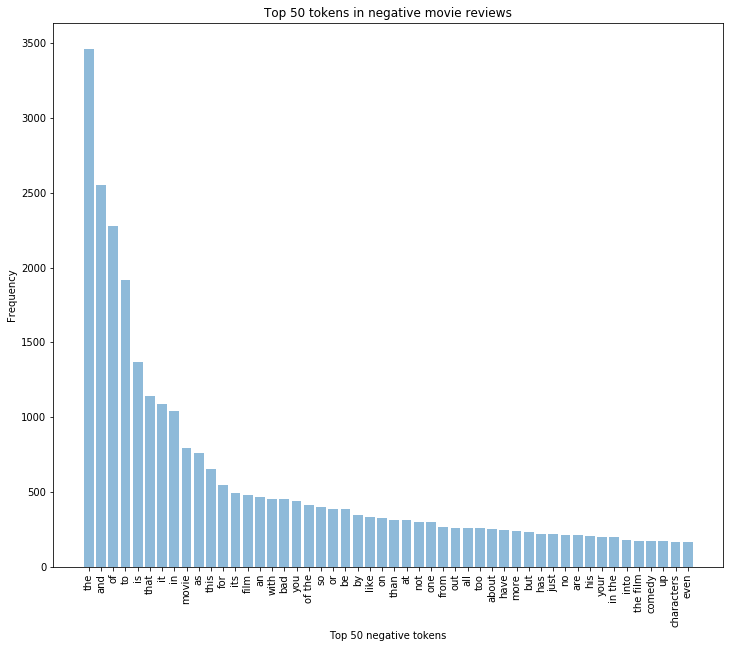

In [83]:
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df.sort_values(by='negative', ascending=False)['negative'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df.sort_values(by='negative', ascending=False)['negative'][:50].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 negative tokens')
plt.title('Top 50 tokens in negative movie reviews')

### Top 50 positive tokens

Text(0.5, 1.0, 'Top 50 tokens in positive movie reviews')

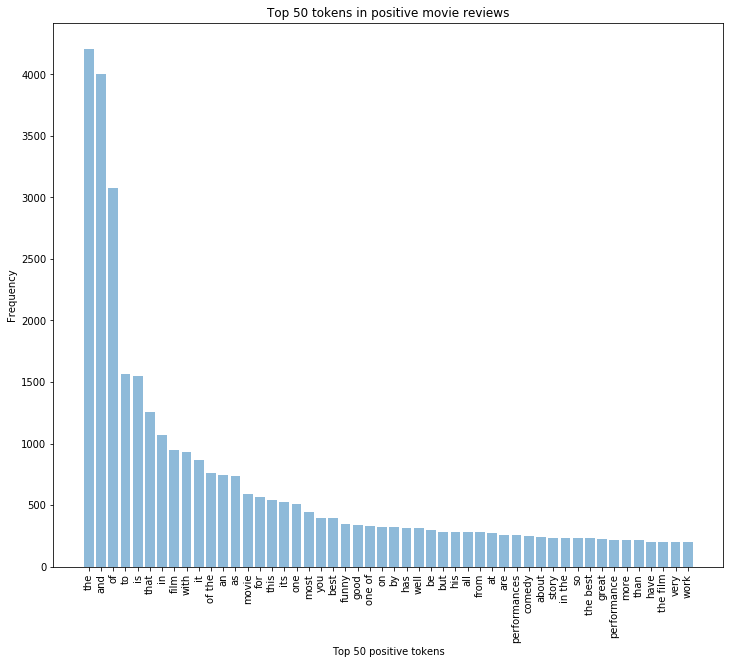

In [84]:
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df.sort_values(by='positive', ascending=False)['positive'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df.sort_values(by='positive', ascending=False)['positive'][:50].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 positive tokens')
plt.title('Top 50 tokens in positive movie reviews')

In [85]:
phrase = np.array(df_train_1['Phrase'])
sentiments = np.array(df_train_1['Sentiment'])
# build train and test datasets

from sklearn.model_selection import train_test_split    
phrase_train, phrase_test, sentiments_train, sentiments_test = train_test_split(phrase, sentiments, test_size=0.2, random_state=4)

### Setting paramenter of CountVectorizer

In [86]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

## Build Bag-Of-Words on train phrases
cv = CountVectorizer(stop_words='english',max_features=10000)
cv_train_features = cv.fit_transform(phrase_train)

In [87]:
# build TFIDF features on train reviews
tv = TfidfVectorizer(min_df=0.0, max_df=1.0, ngram_range=(1,2),
                     sublinear_tf=True)
tv_train_features = tv.fit_transform(phrase_train)

In [88]:
# transform test reviews into features
cv_test_features = cv.transform(phrase_test)
tv_test_features = tv.transform(phrase_test)

In [89]:
print('BOW model:> Train features shape:', cv_train_features.shape, ' Test features shape:', cv_test_features.shape)
print('TFIDF model:> Train features shape:', tv_train_features.shape, ' Test features shape:', tv_test_features.shape)

BOW model:> Train features shape: (124848, 10000)  Test features shape: (31212, 10000)
TFIDF model:> Train features shape: (124848, 93697)  Test features shape: (31212, 93697)


In [90]:
from sklearn import metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.preprocessing import label_binarize
from scipy import interp
from sklearn.metrics import roc_curve, auc 


def get_metrics(true_labels, predicted_labels):
    
    print('Accuracy:', np.round(
                        metrics.accuracy_score(true_labels, 
                                               predicted_labels),
                        4))
    print('Precision:', np.round(
                        metrics.precision_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('Recall:', np.round(
                        metrics.recall_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('F1 Score:', np.round(
                        metrics.f1_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
                        

def train_predict_model(classifier, 
                        train_features, train_labels, 
                        test_features, test_labels):
    # build model    
    classifier.fit(train_features, train_labels)
    # predict using model
    predictions = classifier.predict(test_features) 
    return predictions    


def display_confusion_matrix(true_labels, predicted_labels, classes=[1,0]):
    
    total_classes = len(classes)
    level_labels = [total_classes*[0], list(range(total_classes))]

    cm = metrics.confusion_matrix(y_true=true_labels, y_pred=predicted_labels, 
                                  labels=classes)
    cm_frame = pd.DataFrame(data=cm, 
                            columns=pd.MultiIndex(levels=[['Predicted:'], classes], 
                                                  labels=level_labels), 
                            index=pd.MultiIndex(levels=[['Actual:'], classes], 
                                                labels=level_labels)) 
    print(cm_frame) 
    
def display_classification_report(true_labels, predicted_labels, classes=[1,0]):

    report = metrics.classification_report(y_true=true_labels, 
                                           y_pred=predicted_labels, 
                                           labels=classes) 
    print(report)
    
    
    
def display_model_performance_metrics(true_labels, predicted_labels, classes=[1,0]):
    print('Model Performance metrics:')
    print('-'*30)
    get_metrics(true_labels=true_labels, predicted_labels=predicted_labels)
    print('\nModel Classification report:')
    print('-'*30)
    display_classification_report(true_labels=true_labels, predicted_labels=predicted_labels, 
                                  classes=classes)
    print('\nPrediction Confusion Matrix:')
    print('-'*30)
    display_confusion_matrix(true_labels=true_labels, predicted_labels=predicted_labels, 
                             classes=classes)


def plot_model_decision_surface(clf, train_features, train_labels,
                                plot_step=0.02, cmap=plt.cm.RdYlBu,
                                markers=None, alphas=None, colors=None):
    
    if train_features.shape[1] != 2:
        raise ValueError("X_train should have exactly 2 columnns!")
    
    x_min, x_max = train_features[:, 0].min() - plot_step, train_features[:, 0].max() + plot_step
    y_min, y_max = train_features[:, 1].min() - plot_step, train_features[:, 1].max() + plot_step
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    clf_est = clone(clf)
    clf_est.fit(train_features,train_labels)
    if hasattr(clf_est, 'predict_proba'):
        Z = clf_est.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
    else:
        Z = clf_est.predict(np.c_[xx.ravel(), yy.ravel()])    
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap)
    
    le = LabelEncoder()
    y_enc = le.fit_transform(train_labels)
    n_classes = len(le.classes_)
    plot_colors = ''.join(colors) if colors else [None] * n_classes
    label_names = le.classes_
    markers = markers if markers else [None] * n_classes
    alphas = alphas if alphas else [None] * n_classes
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y_enc == i)
        plt.scatter(train_features[idx, 0], train_features[idx, 1], c=color,
                    label=label_names[i], cmap=cmap, edgecolors='black', 
                    marker=markers[i], alpha=alphas[i])
    plt.legend()
    plt.show()


def plot_model_roc_curve(clf, features, true_labels, label_encoder=None, class_names=None):
    
    ## Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    if hasattr(clf, 'classes_'):
        class_labels = clf.classes_
    elif label_encoder:
        class_labels = label_encoder.classes_
    elif class_names:
        class_labels = class_names
    else:
        raise ValueError('Unable to derive prediction classes, please specify class_names!')
    n_classes = len(class_labels)
    y_test = label_binarize(true_labels, classes=class_labels)
    if n_classes == 2:
        if hasattr(clf, 'predict_proba'):
            prob = clf.predict_proba(features)
            y_score = prob[:, prob.shape[1]-1] 
        elif hasattr(clf, 'decision_function'):
            prob = clf.decision_function(features)
            y_score = prob[:, prob.shape[1]-1]
        else:
            raise AttributeError("Estimator doesn't have a probability or confidence scoring system!")
        
        fpr, tpr, _ = roc_curve(y_test, y_score)      
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='ROC curve (area = {0:0.2f})'
                                 ''.format(roc_auc),
                 linewidth=2.5)
        
    elif n_classes > 2:
        if hasattr(clf, 'predict_proba'):
            y_score = clf.predict_proba(features)
        elif hasattr(clf, 'decision_function'):
            y_score = clf.decision_function(features)
        else:
            raise AttributeError("Estimator doesn't have a probability or confidence scoring system!")

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        ## Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        ## Compute macro-average ROC curve and ROC area
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])
        # Finally average it and compute AUC
        mean_tpr /= n_classes
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        ## Plot ROC curves
        plt.figure(figsize=(6, 4))
        plt.plot(fpr["micro"], tpr["micro"],
                 label='micro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["micro"]), linewidth=3)

        plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["macro"]), linewidth=3)

        for i, label in enumerate(class_labels):
            plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                           ''.format(label, roc_auc[i]), 
                     linewidth=2, linestyle=':')
    else:
        raise ValueError('Number of classes should be atleast 2 or more')
        
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [91]:
from sklearn.linear_model import SGDClassifier, LogisticRegression

lr = LogisticRegression(penalty='l2', max_iter=100, C=1)
sgd = SGDClassifier(loss='hinge', n_iter=100)

### Logistic Regression of CountVectorizer

In [92]:
# Logistic Regression model on BOW features
lr_bow_predictions = train_predict_model(classifier=lr, 
                                             train_features=cv_train_features, train_labels=sentiments_train,
                                             test_features=cv_test_features, test_labels=sentiments_test)
display_model_performance_metrics(true_labels=sentiments_test, predicted_labels=lr_bow_predictions,
                                      classes=[0,1,2,3,4])

Model Performance metrics:
------------------------------
Accuracy: 0.6276
Precision: 0.6082
Recall: 0.6276
F1 Score: 0.5966

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.55      0.25      0.35      1426
           1       0.54      0.32      0.40      5428
           2       0.66      0.89      0.76     15995
           3       0.57      0.40      0.47      6603
           4       0.57      0.32      0.41      1760

   micro avg       0.63      0.63      0.63     31212
   macro avg       0.58      0.44      0.48     31212
weighted avg       0.61      0.63      0.60     31212


Prediction Confusion Matrix:
------------------------------
          Predicted:                        
                   0     1      2     3    4
Actual: 0        360   574    442    48    2
        1        228  1739   3210   236   15
        2         48   727  14291   877   52
        3         15   184   3410  2636

### Logistic Regression on TF-IDF Features

In [93]:
# Logistic Regression model on TF-IDF features
lr_tfidf_predictions = train_predict_model(classifier=lr, 
                                               train_features=tv_train_features, train_labels=sentiments_train,
                                               test_features=tv_test_features, test_labels=sentiments_test)
display_model_performance_metrics(true_labels=sentiments_test, predicted_labels=lr_tfidf_predictions,
                                      classes=[0,1,2,3,4])

Model Performance metrics:
------------------------------
Accuracy: 0.6335
Precision: 0.6216
Recall: 0.6335
F1 Score: 0.5985

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.65      0.18      0.28      1426
           1       0.55      0.33      0.42      5428
           2       0.65      0.90      0.76     15995
           3       0.60      0.43      0.50      6603
           4       0.61      0.23      0.33      1760

   micro avg       0.63      0.63      0.63     31212
   macro avg       0.61      0.41      0.46     31212
weighted avg       0.62      0.63      0.60     31212


Prediction Confusion Matrix:
------------------------------
          Predicted:                        
                   0     1      2     3    4
Actual: 0        258   665    482    20    1
        1        123  1810   3377   109    9
        2         18   682  14468   797   30
        3          0   101   3449  2840